# Knn 
We have ~500K recipes and we would like to cluster these recipes. We have pre-processed the data and scaled all the numeric values. also we used some llm pretrained models to generate embedding from the text data for each recipe. Now before doing any neural network, we would like to perfom some analysis to understand how the data looks like and can we find similar recipes and can we do clustering in the space of the input features. 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [72]:
MODEL_NAME = "all-mpnet-base-v2" # The pretrained model that was used to embed the text

In [73]:


# Load the file, explicitly setting allow_pickle=True
data = np.load(f"input_data/{MODEL_NAME}_vae_input_data.npz", allow_pickle=True)

# These commands will now work:
text_embeds = data["text_embeds"]
numeric_scaled = data["numeric_scaled"]
recipes_df_loaded = data["recipes"] 

# If 'recipes' was saved as a NumPy object array containing a single DataFrame object,
# you will need to extract the DataFrame from the resulting 0-dim array:
recipes_df = pd.DataFrame(data["recipes"], index=None).drop(columns=['Unnamed: 0'])

# If it was saved as a simple object array (less likely for a full df), the .item() might not be needed.
# If the .item() call fails, just use recipes_df = recipes_df_loaded

print("Data loaded successfully!")
# print(type(recipes_df)) # Should show <class 'pandas.core.frame.DataFrame'>

Data loaded successfully!


In [74]:
print(text_embeds.shape)
print(numeric_scaled.shape)
print(recipes_df.shape)

(506933, 768)
(506933, 11)
(506933, 19)


In [75]:
recipes_df.head()

,RecipeId,Name,AuthorId,AuthorName,DatePublished,RecipeCategory,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions,PrepTime_minutes,TotalTime_minutes
0,39,Biryani,1567,elly9812,1999-08-29T13:12:00Z,Chicken Breast,"c(""saffron"", ""milk"", ""hot green chili peppers""...",1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,"c(""Soak saffron in warm milk for 5 minutes and...",240.0,265.0
1,40,Best Lemonade,1566,Stephen Little,1999-09-05T19:52:00Z,Beverages,"c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,"c(""Into a 1 quart Jar with tight fitting lid, ...",30.0,35.0
2,42,Cabbage Soup,1538,Duckie067,1999-09-19T06:19:00Z,Vegetable,"c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,"c(""Mix everything together and bring to a boil...",20.0,50.0
3,43,Best Blackbottom Pie,34879,Barefoot Beachcomber,1999-08-21T10:35:00Z,Pie,"c(""graham cracker crumbs"", ""sugar"", ""butter"", ...",437.9,19.3,10.9,94.3,267.6,58.0,1.8,42.5,7.0,"c(""Graham Cracker Crust: In small bowl, combin...",20.0,140.0
4,44,Warm Chicken A La King,1596,Joan Edington,1999-09-17T04:47:00Z,Chicken,"c(""chicken"", ""butter"", ""flour"", ""milk"", ""celer...",895.5,66.8,31.9,405.8,557.2,29.1,3.1,5.0,45.3,"c(""Melt 1 1/2 ozs butter, add the flour and co...",35.0,38.0


In [77]:
X = np.hstack([text_embeds, numeric_scaled])
print("Combined shape:", X.shape)
n_dim = X.shape[1]

Combined shape: (506933, 779)


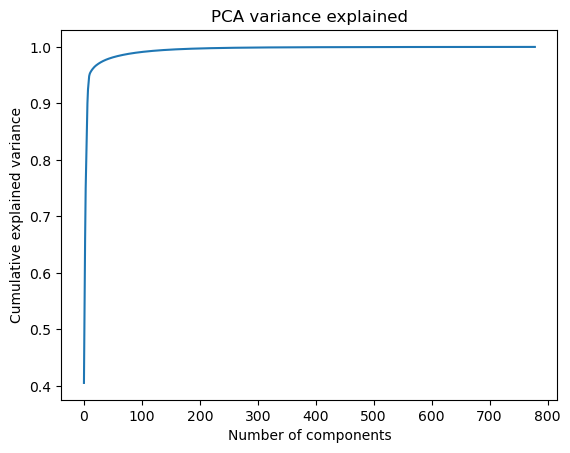

In [78]:
pca = PCA(n_components=n_dim)
X_pca = pca.fit_transform(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA variance explained")
plt.show()

In [81]:
np.cumsum(pca.explained_variance_ratio_)[50]

np.float64(0.981583011081094)

Since 50 components can explain more than 98 percents of the data, we keep 50 and discard the rest

In [91]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

In [92]:
X_pca.shape

(506933, 50)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

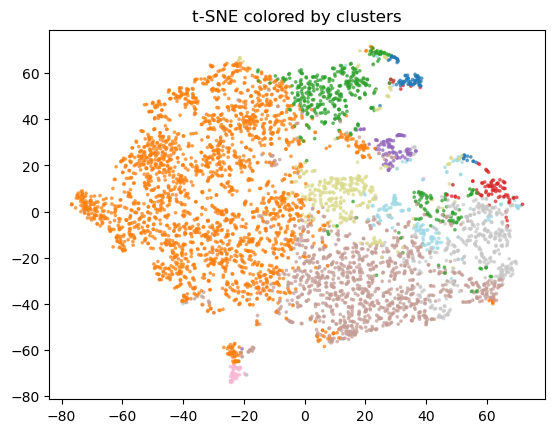

In [104]:
sample_idx = np.random.choice(len(X_pca), 5000, replace=False)
X_2d = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(X_pca[sample_idx])

kmeans = MiniBatchKMeans(n_clusters=10, batch_size=4096, random_state=42)
labels = kmeans.fit_predict(X)

recipes_df["cluster"] = labels

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels[sample_idx], cmap='tab20', s=3, alpha=0.6)
plt.title("t-SNE colored by clusters")
plt.show()

In [114]:
for c in range(3):
    print(f"\nCluster {c} sample recipes:")
    print(recipes_df[recipes_df.cluster == c][["Name", "RecipeInstructions"]].head(5))


Cluster 0 sample recipes:
                                         Name  \
82                    Blueberry Pancake Syrup   
91                     Caramel Sultana Square   
110  Coconut Shrimp With Orange Mustard Sauce   
153    Crock Pot Chocolate Zucchini Nut Bread   
230                                Rock Candy   

                                    RecipeInstructions  
82   c("Pour the blueberries into a saucepan and cr...  
91   c("Cream butter and sugar, add egg then dry in...  
110  c("Peel and devein the shrimp leaving the tail...  
153  c("Cream sugar and shortening in mixer, beat i...  
230  c("* Candy flavoring is carried by a lot of gr...  

Cluster 1 sample recipes:
                                         Name  \
1                               Best Lemonade   
2                                Cabbage Soup   
5  Buttermilk Pie With Gingersnap Crumb Crust   
6                     A Jad - Cucumber Pickle   
7                        Butter Pecan Cookies   

              

In [121]:
recipes_df[recipes_df.cluster == 9]['RecipeInstructions'][0:1]

22    c("In a medium stockpot or Dutch oven heat oli...
Name: RecipeInstructions, dtype: object